# Data merge

El proyecto se ha realizado con datos de minuto de los activos QQQ y BTC/USD.

En este notebook se unen los distintos dataframes para poder utilizarlos en un entorno local, debido a que su tamaño impide logearlos a github.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

## Datos BTC

La serie temporal de datos de bitcoin está dividida en 4:
* Periodo In-sample:
    - BTC_1min_2018-01-01_to_2020-12-31
    - BTC_1min_2021-01-01_to_2021-12-31
* Periodo out-of-sample:
    - BTC_1min_2024-01-01_to_2024-06-30

El formato de la serie es de datos de 1minuto para un horario de mercado continuo (24 horas 365 días del año).
En la serie temporal hay ciertos intervalos de minutos donde no se tienen muestras. Para estos casos, los datos faltantes se completan utilizando el valor previo más cercano disponible en la serie.

In [ ]:
# load BTC data
btc_2018_2021 = pd.read_parquet(r'BTC_1min_2018-01-01_to_2020-12-31.parquet')
btc_2021_2023 = pd.read_parquet(r'BTC_1min_2021-01-01_to_2022-12-31.parquet')

btc_2023_2024 = pd.read_parquet(r'BTC_1min_2024-01-01_to_2024-06-30.parquet')

In [ ]:
# # In sample data: de 2018 a 2023
# btc_series_1 = pd.concat([btc_2018_2021, btc_2021_2023, ]).drop_duplicates()
# btc_series_1.set_index('date', inplace=True)
# btc_series_1 = btc_series_1.sort_index()

# # Sout of sample data: de 2023 
# btc_series_2 = btc_2023_2024
# btc_series_2.set_index('date', inplace=True)
# btc_series_2 = btc_series_2.sort_index()

In [ ]:
# serie completa
btc_series_1 = pd.concat([btc_2018_2021, btc_2021_2023, btc_2023_2024]).drop_duplicates()
btc_series_1.set_index('date', inplace=True)
btc_series_1 = btc_series_1.sort_index()

In [ ]:
btc_series_1.head()

,open,low,high,close,volume
date,,,,,
2018-01-01 00:00:00,13584.00,13541.93,13765.00,13541.93,558350.459454
2018-01-01 00:01:00,13607.14,13517.20,13658.75,13565.23,361676.256267
2018-01-01 00:02:00,13565.23,13534.49,13765.00,13587.30,387113.155403
2018-01-01 00:03:00,13563.00,13527.76,13765.00,13550.34,556212.790172
2018-01-01 00:04:00,13552.00,13531.02,13887.90,13560.14,345138.597671


### Añadir valores faltantes a la serie BTC

In [7]:
def find_missing_timestamps(df: pd.DataFrame):
    """
    Encuentra las marcas de tiempo faltantes en una serie temporal y devuelve una lista de ellas.
    """
    # Generar una serie temporal completa desde el primer hasta el último timestamp en incrementos de 1 minuto
    full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')
    
    # Reindexar el DataFrame para incluir todas las marcas de tiempo en el rango
    df_reindexed = df.reindex(full_time_range)
    
    # Identificar las marcas de tiempo faltantes
    missing_timestamps = df_reindexed[df_reindexed.isna().any(axis=1)].index
    
    return missing_timestamps

In [8]:
# missing_timestamps_in_sample_btc = find_missing_timestamps(btc_series_1)
# print(f"{len(missing_timestamps_in_sample_btc)} muestras faltantes en la serie in-sample")
# print(f'Longitud de la serie in-sample original: {len(btc_series_1)}')

# missing_timestamps_out_of_sample_btc = find_missing_timestamps(btc_series_2)
# print(f"{len(missing_timestamps_out_of_sample_btc)} muestras faltantes en la serie out-of-sample")
# print(f'Longitud de la serie in-sample original: {len(btc_series_2)}')

In [9]:
missing_timestamps_in_sample_btc = find_missing_timestamps(btc_series_1)
print(f"{len(missing_timestamps_in_sample_btc)} muestras faltantes en la serie in-sample")
print(f'Longitud de la serie in-sample original: {len(btc_series_1)}')

3640 muestras faltantes en la serie in-sample
Longitud de la serie in-sample original: 3413480


In [10]:
def fill_missing_timestamps(df: pd.DataFrame):
    """
    Llena las marcas de tiempo faltantes en una serie temporal utilizando el valor previo más cercano.
    """
    # Generar una serie temporal completa desde el primer hasta el último timestamp en incrementos de 1 minuto
    full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')
    
    # Reindexar el DataFrame para incluir todas las marcas de tiempo en el rango
    df_reindexed = df.reindex(full_time_range)
    
    # Llenar los valores faltantes con el valor previo de la serie
    ohlc_columns = ['open', 'high', 'low', 'close']
    df_reindexed[ohlc_columns] = df_reindexed[ohlc_columns].ffill()
    
    # Llenar los valores faltantes con la media del volumen
    df_reindexed['volume'] = df_reindexed['volume'].fillna(df['volume'].mean())
    
    # Restablecer el índice y convertir el índice datetime a una columna llamada 'date'
    df_filled = df_reindexed.reset_index()
    df_filled.rename(columns={'index': 'date'}, inplace=True)
    
    return df_filled

In [11]:
# btc_series_1_filled = fill_missing_timestamps(btc_series_1)
# print(f'Longitud de la serie in-sample procesada: {len(btc_series_1_filled)}')


# btc_series_2_filled = fill_missing_timestamps(btc_series_2)
# print(f'Longitud de la serie out-of-sample procesada: {len(btc_series_2_filled)}')

In [12]:
btc_series_1_filled = fill_missing_timestamps(btc_series_1)
print(f'Longitud de la serie in-sample procesada: {len(btc_series_1_filled)}')

Longitud de la serie in-sample procesada: 3417120


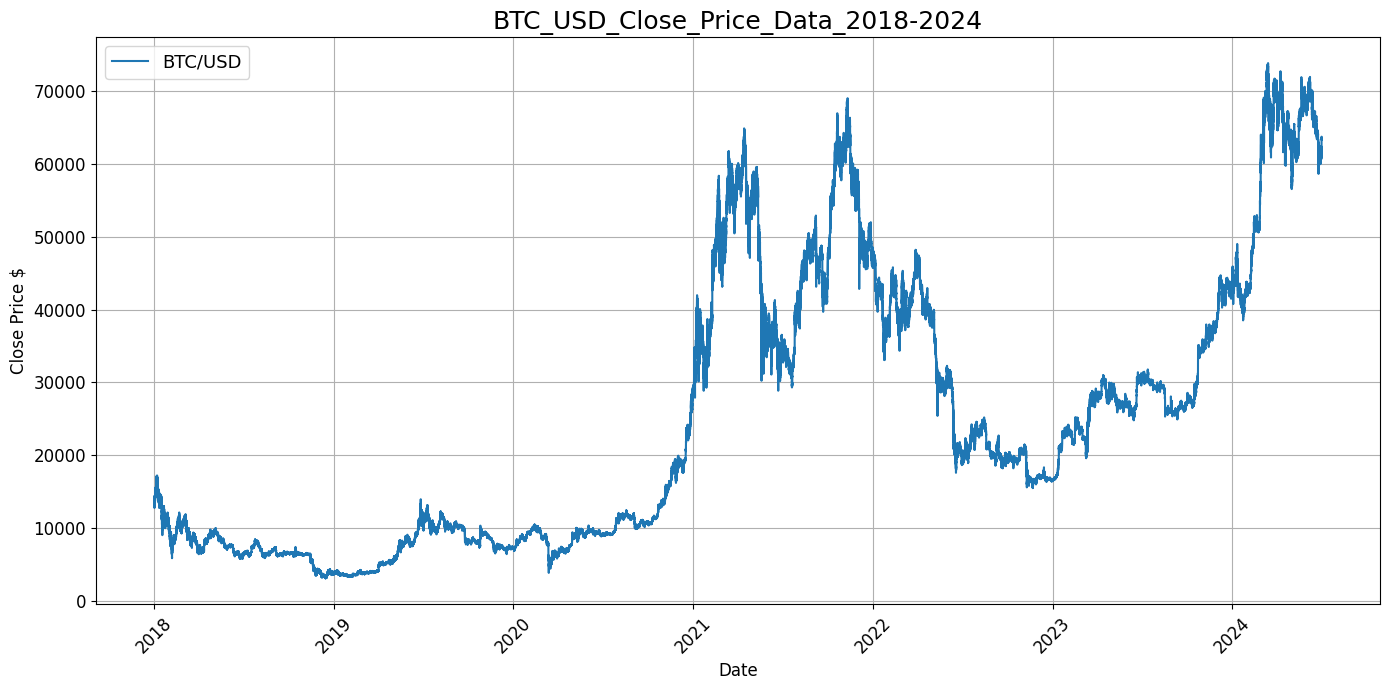

In [13]:
# Crear gráfico
plt.figure(figsize=(14, 7))

# Graficar la primera serie temporal
plt.plot(btc_series_1_filled['date'], btc_series_1_filled['close'], label='BTC/USD')  # Suponiendo que la columna a graficar se llama 'value'

# # Graficar la segunda serie temporal
# plt.plot(btc_series_2_filled['date'], btc_series_2_filled['close'], label='Out-of-sample', color='orange')  # Suponiendo que la columna a graficar se llama 'value'

# Configurar etiquetas y leyenda
filename = 'BTC_USD_Close_Price_Data_2018-2024'
plt.title(filename, fontsize = 18)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price $', fontsize = 12)
plt.legend(fontsize = 13)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Guardar la figura
plt.savefig('../tfm/figures/' + filename + '.png')

# Mostrar la figura
plt.show()

In [14]:
## Save data
# btc_series_1_filled.to_parquet(r'BTC_1min_In_Sample_data.parquet')
# btc_series_1_filled.to_parquet(r'BTC_1min_Out_Of_Sample_data.parquet')

## Datos QQQ

La serie temporal de datos de QQQ está dividida en 4:
* Periodo In-sample:
    - QQQ_1min_2018-01-01_to_2020-12-31
    - QQQ_1min_2020-01-01_to_2022-12-31
* Periodo out-of-sample:
    - QQQ_1min_2024-01-01_to_2024-06-30

El formato de la serie es de datos de 1minuto para un horario de mercado normal (lunes a viernes de 9:30 a 16:00 en el horario americano).
En la serie temporal hay ciertos intervalos de minutos donde no se tienen muestras. Para estos casos, los datos faltantes se completan utilizando el valor previo más cercano disponible en la serie.

El qqq cotiza en el nasdaq.

In [15]:
def filter_market_hours(df: pd.DataFrame, start_time: str = '09:30', end_time: str = '16:00') -> pd.DataFrame:
    """
    Filtra el DataFrame para incluir solo los valores dentro del horario de mercado.
    """
    market_open = df.between_time(start_time, end_time)
    return market_open

In [16]:
# load QQQ data
qqq_2018_2020 = pd.read_parquet(r'QQQ_1min_2018-01-01_to_2020-12-31.parquet')
qqq_2020_2023 = pd.read_parquet(r'QQQ_1min_2021-01-01_to_2022-12-31.parquet')

qqq_2023_2024 = pd.read_parquet(r'QQQ_1min_2024-01-01_to_2024-06-30.parquet')

In [17]:
# In sample data: de 2018 a 2023
qqq_series_1 = pd.concat([qqq_2018_2020, qqq_2020_2023]).drop_duplicates()
qqq_series_1.set_index('date', inplace=True)
qqq_series_1 = qqq_series_1.sort_index()
qqq_series_1_filtered = filter_market_hours(qqq_series_1)
print(f"Serie antes de filtrar: {len(qqq_series_1)} | después: {len(qqq_series_1_filtered)}")

# Sout of sample data: de 2023 
qqq_series_2 = qqq_2023_2024
qqq_series_2.set_index('date', inplace=True)
qqq_series_2 = qqq_series_2.sort_index()
qqq_series_2_filtered = filter_market_hours(qqq_series_2)
print(f"Serie antes de filtrar: {len(qqq_series_2)} | después: {len(qqq_series_2_filtered)}")


Serie antes de filtrar: 1225199 | después: 588991
Serie antes de filtrar: 118104 | después: 48484


In [18]:
# Función para eliminar valores fuera del horario de mercado

# Función para encontrar las marcas de tiempo faltantes dentro del horario de mercado
def find_missing_market_hours(df: pd.DataFrame, start_time: str = '09:30', end_time: str = '16:00') -> pd.DataFrame:
    """
    Encuentra las marcas de tiempo faltantes dentro del horario de mercado y devuelve un DataFrame con los valores faltantes.

    """
    # Obtener el calendario del mercado de NASDAQ
    nasdaq = mcal.get_calendar('NASDAQ')
    
    # Generar un rango de fechas para los días de mercado
    schedule = nasdaq.schedule(start_date=df.index.min().date(), end_date=df.index.max().date())
    market_days = pd.date_range(start=schedule.index.min(), end=schedule.index.max(), freq='B')

    full_market_range = []
    for day in market_days:
        day_range = pd.date_range(start=f"{day} {start_time}", end=f"{day} {end_time}", freq='min')
        full_market_range.extend(day_range)

    full_market_range = pd.DatetimeIndex(full_market_range)

    # Reindexar el DataFrame para incluir todas las marcas de tiempo en el rango
    df_reindexed = df.reindex(full_market_range)
    
    # Identificar las marcas de tiempo faltantes
    missing_timestamps = df_reindexed[df_reindexed.isna().any(axis=1)]
    
    return missing_timestamps

In [19]:
missing_timestamps_in_sample_qqq = find_missing_market_hours(qqq_series_1_filtered)
print(f"{len(missing_timestamps_in_sample_qqq)} muestras faltantes en la serie in-sample")
print(f'Longitud de la serie in-sample original: {len(qqq_series_1_filtered)}')

missing_timestamps_out_of_sample_qqq = find_missing_market_hours(qqq_series_2_filtered)
print(f"{len(missing_timestamps_out_of_sample_qqq)} muestras faltantes en la serie out-of-sample")
print(f'Longitud de la serie in-sample original: {len(qqq_series_2_filtered)}')

22533 muestras faltantes en la serie in-sample
Longitud de la serie in-sample original: 588991
1955 muestras faltantes en la serie out-of-sample
Longitud de la serie in-sample original: 48484


In [20]:
def fill_missing_timestamps_with_time(df: pd.DataFrame, start_time: str = '09:30', end_time: str = '16:00') -> pd.DataFrame:
    """
    Encuentra las marcas de tiempo faltantes dentro del horario de mercado y devuelve un DataFrame con los valores faltantes.

    """
    # Obtener el calendario del mercado de NASDAQ
    nasdaq = mcal.get_calendar('NASDAQ')
    
    # Generar un rango de fechas para los días de mercado
    schedule = nasdaq.schedule(start_date=df.index.min().date(), end_date=df.index.max().date())
    market_days = pd.date_range(start=schedule.index.min(), end=schedule.index.max(), freq='B')

    full_market_range = []
    for day in market_days:
        day_range = pd.date_range(start=f"{day} {start_time}", end=f"{day} {end_time}", freq='min')
        full_market_range.extend(day_range)

    full_market_range = pd.DatetimeIndex(full_market_range)

    # Reindexar el DataFrame para incluir todas las marcas de tiempo en el rango
    df_reindexed = df.reindex(full_market_range)
    
    # Llenar los valores faltantes con el valor previo de la serie
    ohlc_columns = ['open', 'high', 'low', 'close']
    df_reindexed[ohlc_columns] = df_reindexed[ohlc_columns].ffill()
    
    # Fill missing values in the 'volume' column with the mean
    df_reindexed['volume'] = df_reindexed['volume'].fillna(df['volume'].mean())
    
    # Restablecer el índice y convertir el índice datetime a una columna llamada 'date'
    df_filled = df_reindexed.reset_index()
    df_filled.rename(columns={'index': 'date'}, inplace=True)
    
    return df_filled

In [21]:
qqq_series_1_filled = fill_missing_timestamps_with_time(qqq_series_1_filtered)
print(f'Longitud de la serie in-sample procesada: {len(qqq_series_1_filled)}')


qqq_series_2_filled = fill_missing_timestamps_with_time(qqq_series_2_filtered)
print(f'Longitud de la serie out-of-sample procesada: {len(qqq_series_2_filled)}')

Longitud de la serie in-sample procesada: 611524
Longitud de la serie out-of-sample procesada: 50439


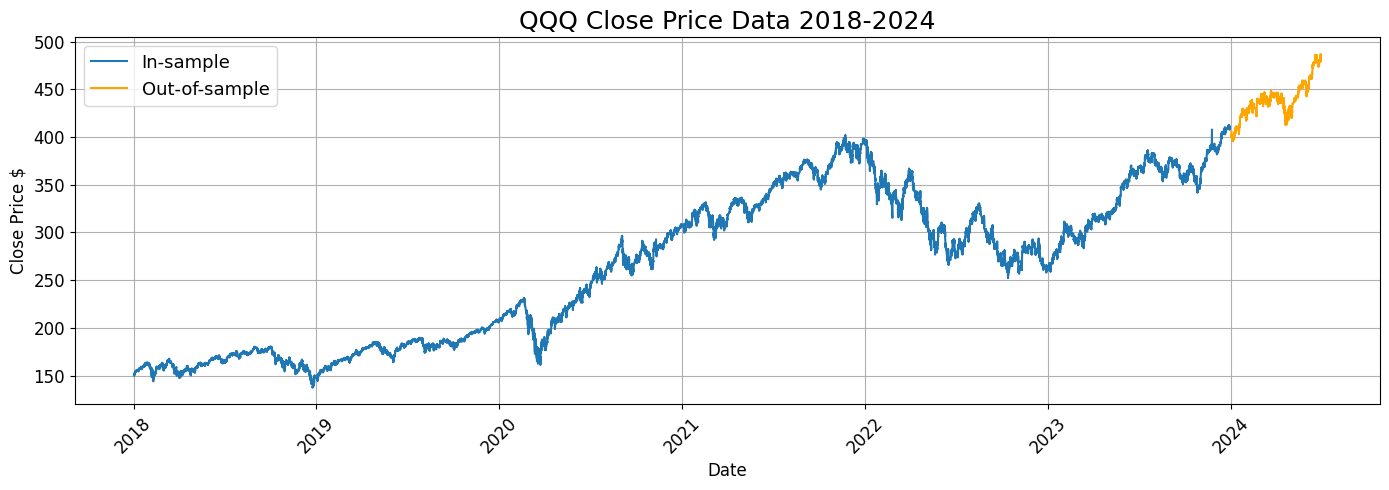

In [22]:
# Crear gráfico
plt.figure(figsize=(14, 5))

# Graficar la primera serie temporal
plt.plot(qqq_series_1_filled['date'], qqq_series_1_filled['close'], label='In-sample')  # Suponiendo que la columna a graficar se llama 'value'

# Graficar la segunda serie temporal
plt.plot(qqq_series_2_filled['date'], qqq_series_2_filled['close'], label='Out-of-sample', color='orange')  # Suponiendo que la columna a graficar se llama 'value'

# Configurar etiquetas y leyenda
plt.title('QQQ Close Price Data 2018-2024', fontsize = 18)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price $', fontsize = 12)
plt.legend(fontsize = 13)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
## Save data
# qqq_series_1_filled.to_parquet(r'QQQ_1min_In_Sample_data.parquet')
# qqq_series_2_filled.to_parquet(r'QQQ_1min_Out_Of_Sample_data.parquet')

# Datos SPY

In [24]:
# load SPY data
spy_2018_2020 = pd.read_csv(r'Historical_Intraday_SPY_1min_2018-01-01_to_2024-06-30.csv')
spy_2020_2023 = pd.read_csv(r'Historical_Intraday_SPY_1min_2020-03-01_to_2024-06-30.csv')

spy_2023_2024 = pd.read_csv(r'Historical_Intraday_SPY_1min_2022-05-01_to_2024-06-30.csv')

In [25]:
spy_2018_2020.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
spy_2020_2023.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
spy_2023_2024.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

In [26]:
# In sample data: de 2018 a 2023
spy_series_1 = pd.concat([spy_2018_2020, spy_2020_2023, spy_2023_2024]).drop_duplicates()
spy_series_1['date'] = pd.to_datetime(spy_series_1['date'])
spy_series_1.set_index('date', inplace=True)
spy_series_1 = spy_series_1.sort_index()
spy_series_1_filtered = filter_market_hours(spy_series_1)
print(f"Serie antes de filtrar: {len(spy_series_1)} | después: {len(spy_series_1_filtered)}")

Serie antes de filtrar: 1375320 | después: 637878


In [27]:
missing_timestamps_in_sample_spy = find_missing_market_hours(spy_series_1_filtered)
print(f"{len(missing_timestamps_in_sample_spy)} muestras faltantes en la serie in-sample")
print(f'Longitud de la serie in-sample original: {len(spy_series_1_filtered)}')


24476 muestras faltantes en la serie in-sample
Longitud de la serie in-sample original: 637878


In [28]:
spy_series_1_filled = fill_missing_timestamps_with_time(spy_series_1_filtered)
print(f'Longitud de la serie in-sample procesada: {len(spy_series_1_filled)}')

Longitud de la serie in-sample procesada: 662354


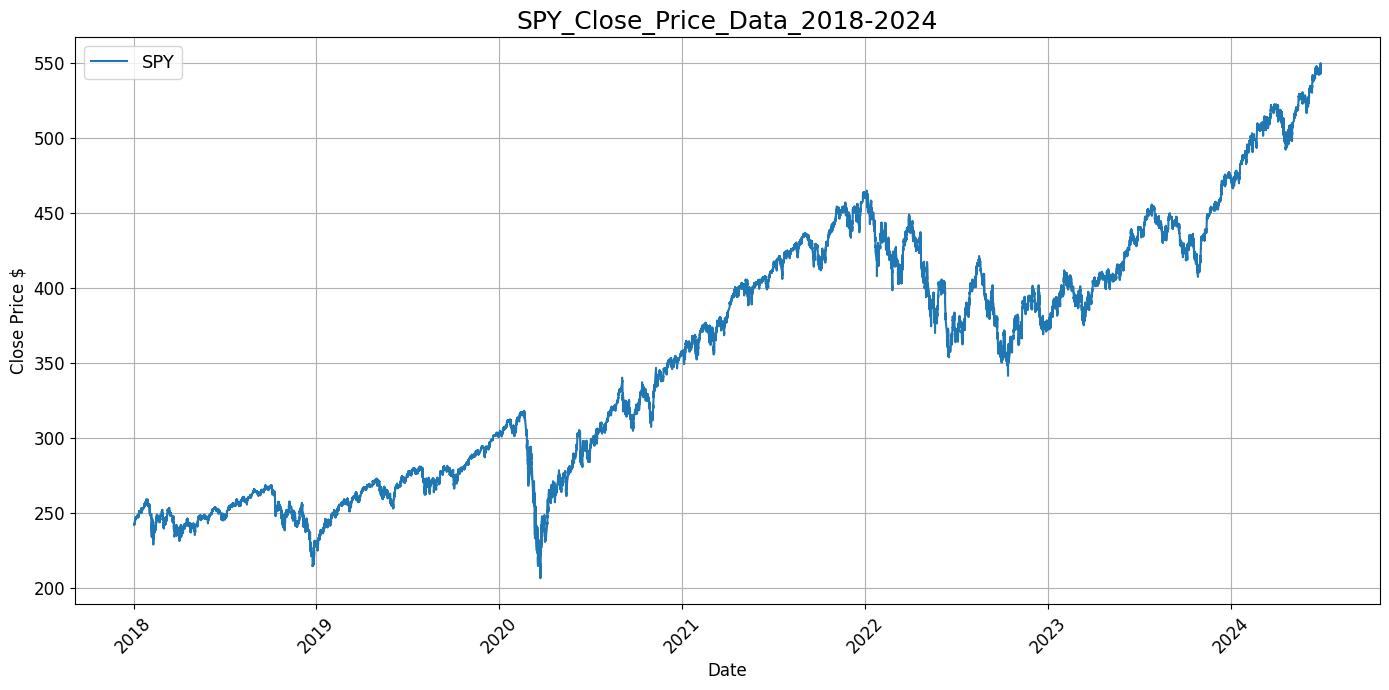

In [29]:
# Crear gráfico
plt.figure(figsize=(14, 7))

# Graficar la primera serie temporal
plt.plot(spy_series_1_filled['date'], spy_series_1_filled['close'], label='SPY')  # Suponiendo que la columna a graficar se llama 'value'

# # Graficar la segunda serie temporal
# plt.plot(qqq_series_2_filled['date'], qqq_series_2_filled['close'], label='Out-of-sample', color='orange')  # Suponiendo que la columna a graficar se llama 'value'

# Configurar etiquetas y leyenda
filename = 'SPY_Close_Price_Data_2018-2024'
plt.title(filename, fontsize = 18)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price $', fontsize = 12)
plt.legend(fontsize = 13)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
# Guardar la figura
plt.savefig('../tfm/figures/' + filename + '.png')

# Mostrar la figura
plt.show()

# Propiedades estadísticas de las series


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

# Configuración de estilo de los gráficos
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6)})


### Bitcoin

In [31]:
# calculo de retornos y volatilidad
btc_series_1_filled['log_returns'] = np.log(btc_series_1_filled['close'] / btc_series_1_filled['close'].shift(1))
btc_series_1_filled.dropna(inplace=True)

window = 30  # 60?
btc_series_1_filled['volatility'] = btc_series_1_filled['log_returns'].rolling(window=window).std()

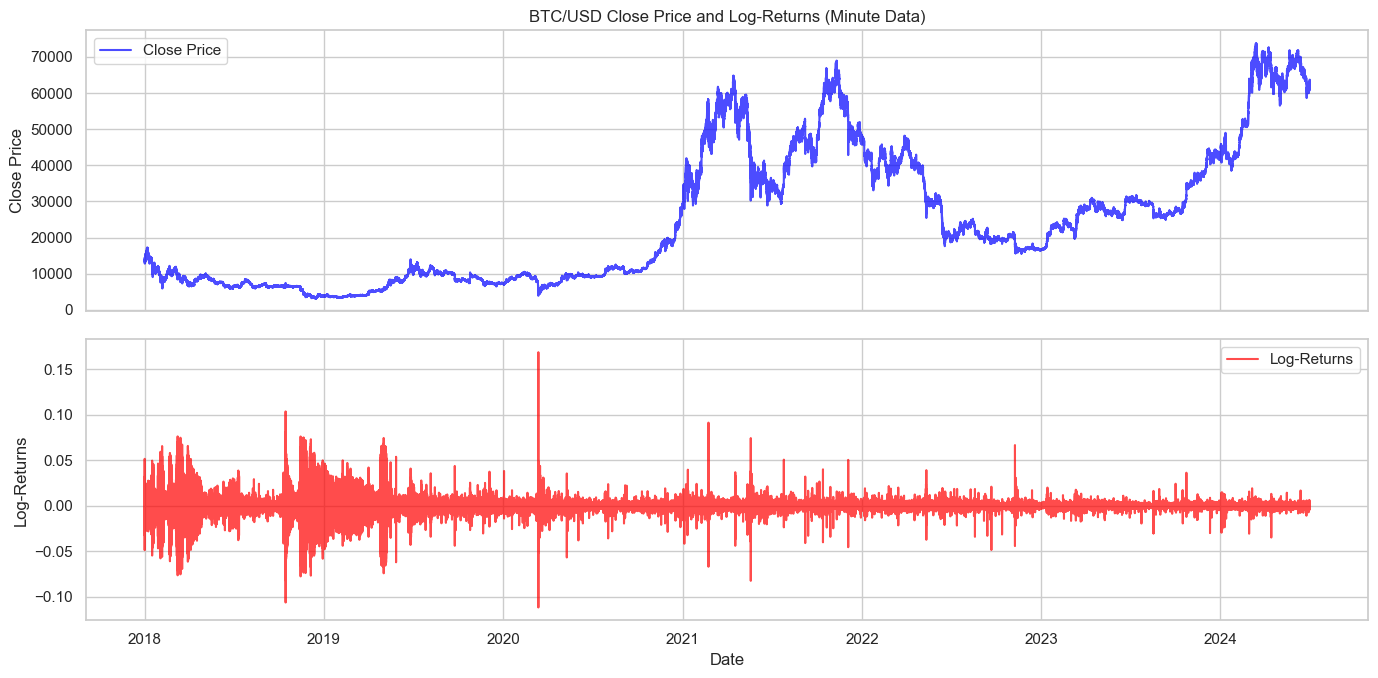

In [32]:
filename = 'BTC_Price&Returns_Data_2018-2024'
# Crear gráfico de precios y log-returns
plt.figure(figsize=(14, 7))

# Graficar precios
ax1 = plt.subplot(2, 1, 1)
ax1.plot(btc_series_1_filled['date'], btc_series_1_filled['close'], label='Close Price', color = 'blue', alpha = 0.7)
ax1.set_title('BTC/USD Close Price and Log-Returns (Minute Data)')
ax1.set_ylabel('Close Price')
ax1.legend()
ax1.grid(True)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Ocultar eje x

# Graficar log-returns
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(btc_series_1_filled['date'], btc_series_1_filled['log_returns'], color='red', label='Log-Returns', alpha = 0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Log-Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

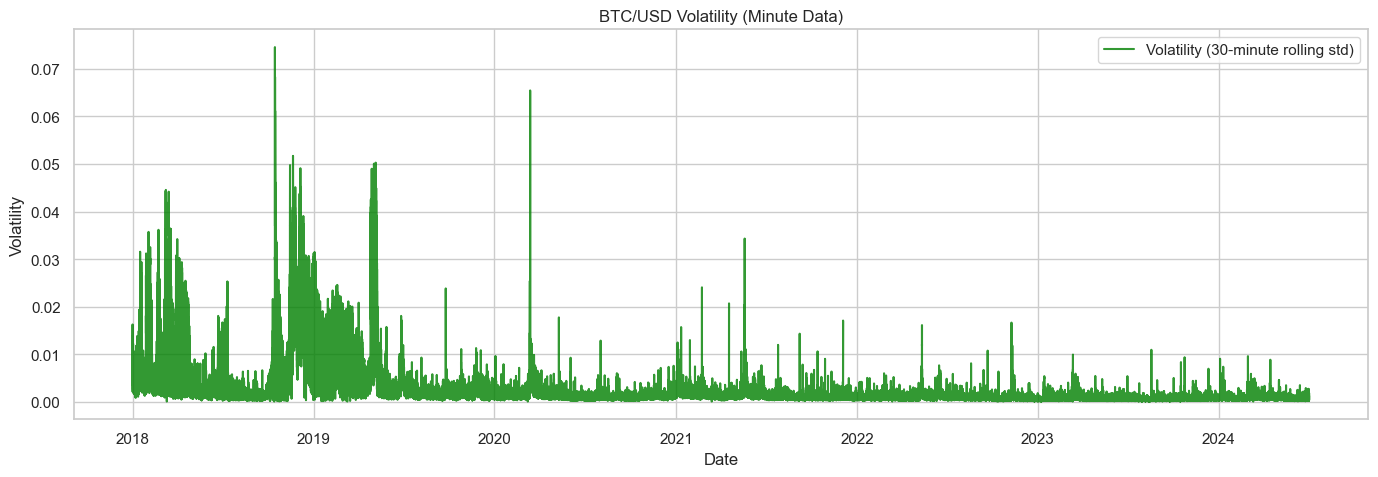

In [33]:
# Gráfico de volatilidad
filename = 'BTC_Volatility_2018-2024'
plt.figure(figsize=(14, 5))
plt.plot(btc_series_1_filled['date'], btc_series_1_filled['volatility'], color='green', label='Volatility (30-minute rolling std)', alpha = 0.8)
plt.title('BTC/USD Volatility (Minute Data)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()


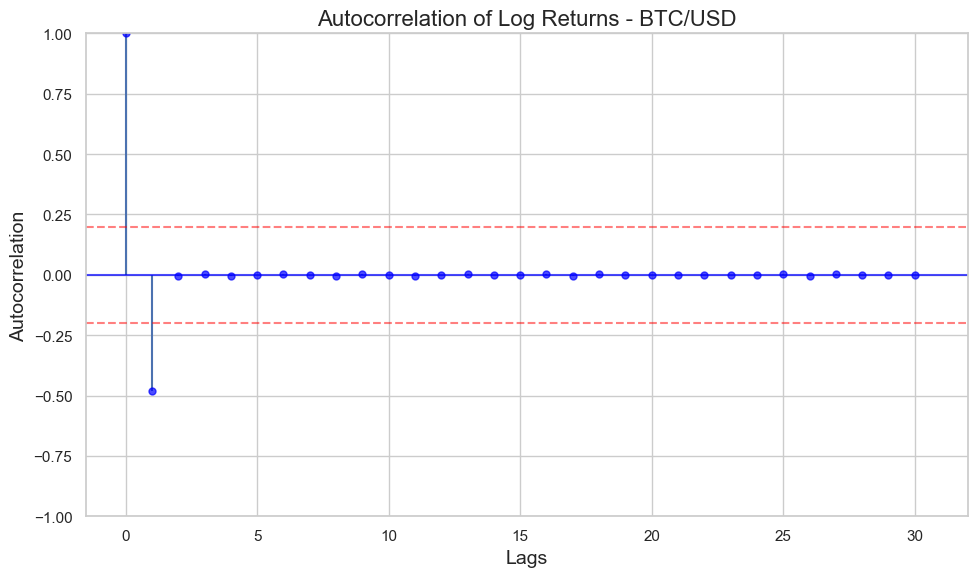

In [34]:
# 1. Autocorrelación de los log-returns
filename = 'BTC_autocorr_log_ret_2018-2024'
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(btc_series_1_filled['log_returns'].dropna(), lags=30, ax=ax)

# Configurar colores y estilos
lines = ax.get_lines()
for line in lines:
    line.set_color('blue')
    line.set_alpha(0.7)
    line.set_markerfacecolor('blue')
    line.set_markeredgecolor('blue')

ax.axhline(y=0.2, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=-0.2, linestyle='--', color='red', alpha=0.5)

ax.set_title('Autocorrelation of Log Returns - BTC/USD', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

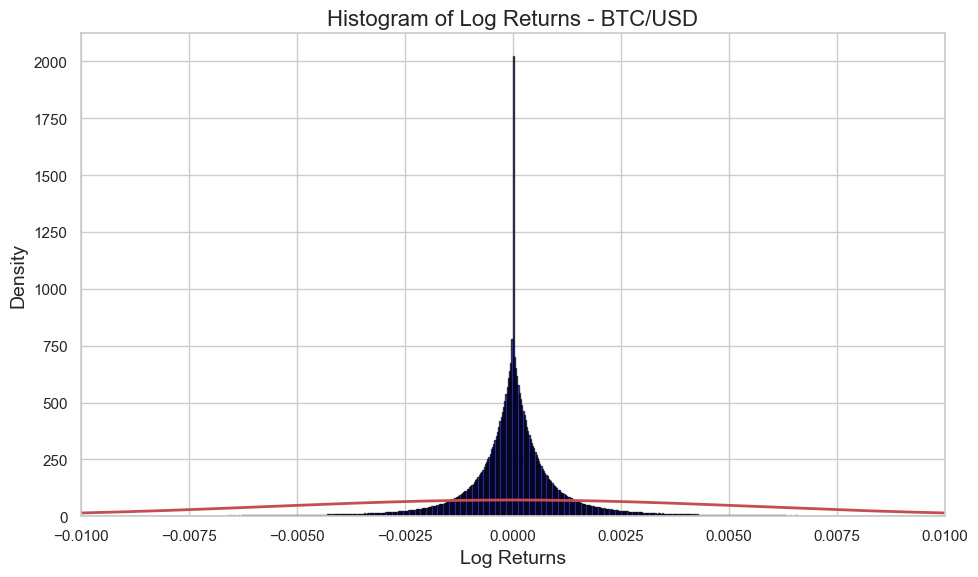

In [38]:
# Histograma de los log-returns
filename = 'BTC_hist_log_ret_2018-2024'
fig, ax = plt.subplots()
log_returns = btc_series_1_filled['log_returns'].dropna()

# Calcular el histograma y obtener los parámetros
count, bins, ignored = ax.hist(log_returns, bins=10000, color='blue', edgecolor='black', alpha=0.7, density=True)

# Ajustar una curva normal a los datos
mu, std = stats.norm.fit(log_returns)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 10000)
p = stats.norm.pdf(x, mu, std)

# Graficar la curva normal ajustada al histograma
ax.plot(x, p, 'r', linewidth=2)

ax.set_title('Histogram of Log Returns - BTC/USD', fontsize=16)
ax.set_xlabel('Log Returns', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([-0.010, 0.010])

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

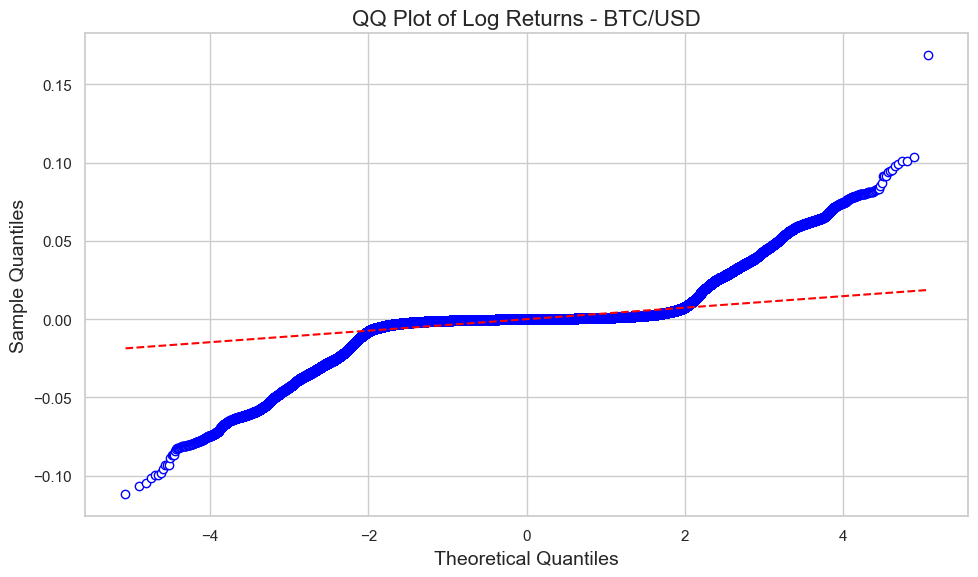

In [35]:
# 3. QQ plot de los log-returns
filename = 'BTC_qq_2018-2024'
fig, ax = plt.subplots()
stats.probplot(btc_series_1_filled['log_returns'].dropna(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('blue')
ax.set_title('QQ Plot of Log Returns - BTC/USD', fontsize=16)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

### SPY

In [36]:
# calculo de retornos y volatilidad
spy_series_1_filled['log_returns'] = np.log(spy_series_1_filled['close'] / spy_series_1_filled['close'].shift(1))
spy_series_1_filled.dropna(inplace=True)

window = 30  # 60?
spy_series_1_filled['volatility'] = spy_series_1_filled['log_returns'].rolling(window=window).std()

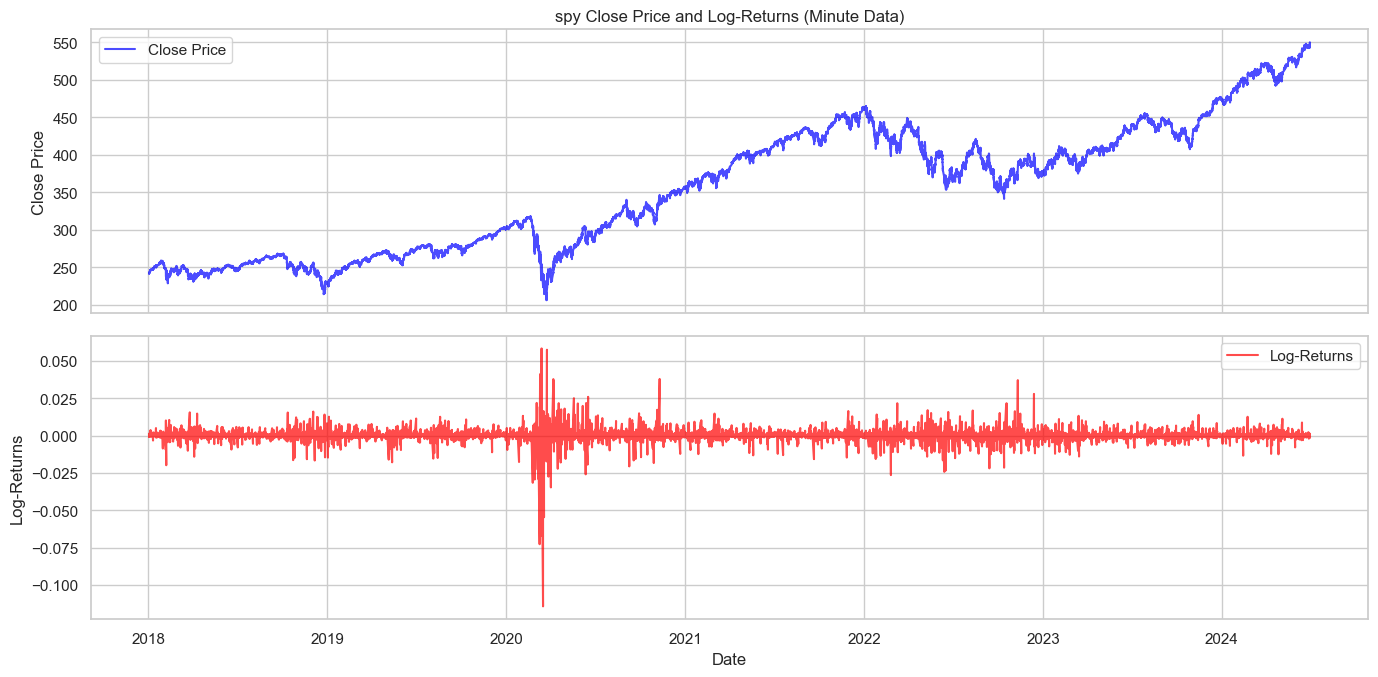

In [37]:
filename = 'SPY_Price&Returns_Data_2018-2024'
# Crear gráfico de precios y log-returns
plt.figure(figsize=(14, 7))

# Graficar precios
ax1 = plt.subplot(2, 1, 1)
ax1.plot(spy_series_1_filled['date'], spy_series_1_filled['close'], label='Close Price', color = 'blue', alpha = 0.7)
ax1.set_title('spy Close Price and Log-Returns (Minute Data)')
ax1.set_ylabel('Close Price')
ax1.legend()
ax1.grid(True)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Ocultar eje x

# Graficar log-returns
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(spy_series_1_filled['date'], spy_series_1_filled['log_returns'], color='red', label='Log-Returns', alpha = 0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Log-Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

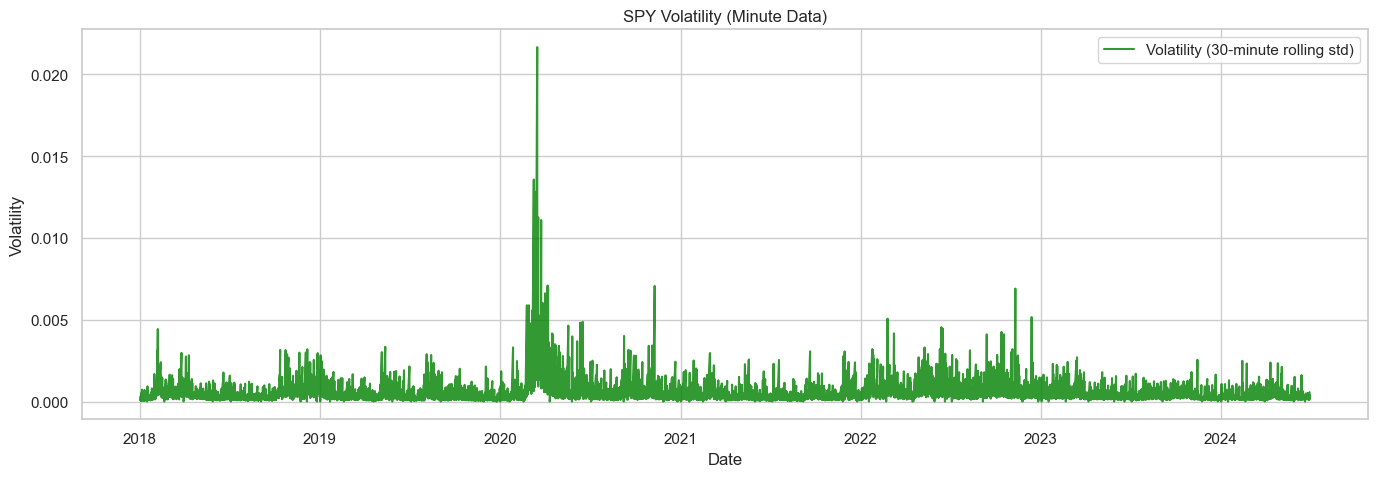

In [38]:
# Gráfico de volatilidad
filename = 'SPY_Volatility_2018-2024'
plt.figure(figsize=(14, 5))
plt.plot(spy_series_1_filled['date'], spy_series_1_filled['volatility'], color='green', label='Volatility (30-minute rolling std)', alpha = 0.8)
plt.title('SPY Volatility (Minute Data)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

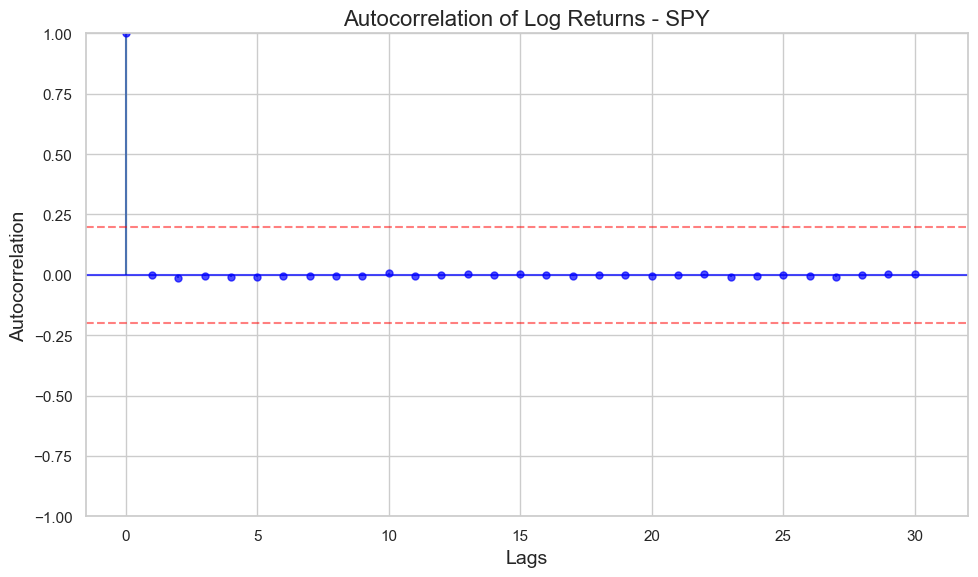

In [39]:
# 1. Autocorrelación de los log-returns
filename = 'SPY_autocorr_log_ret_2018-2024'
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(spy_series_1_filled['log_returns'].dropna(), lags=30, ax=ax)

# Configurar colores y estilos
lines = ax.get_lines()
for line in lines:
    line.set_color('blue')
    line.set_alpha(0.7)
    line.set_markerfacecolor('blue')
    line.set_markeredgecolor('blue')

ax.axhline(y=0.2, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=-0.2, linestyle='--', color='red', alpha=0.5)

ax.set_title('Autocorrelation of Log Returns - SPY', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.get_lines()[0].set_color('blue')
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

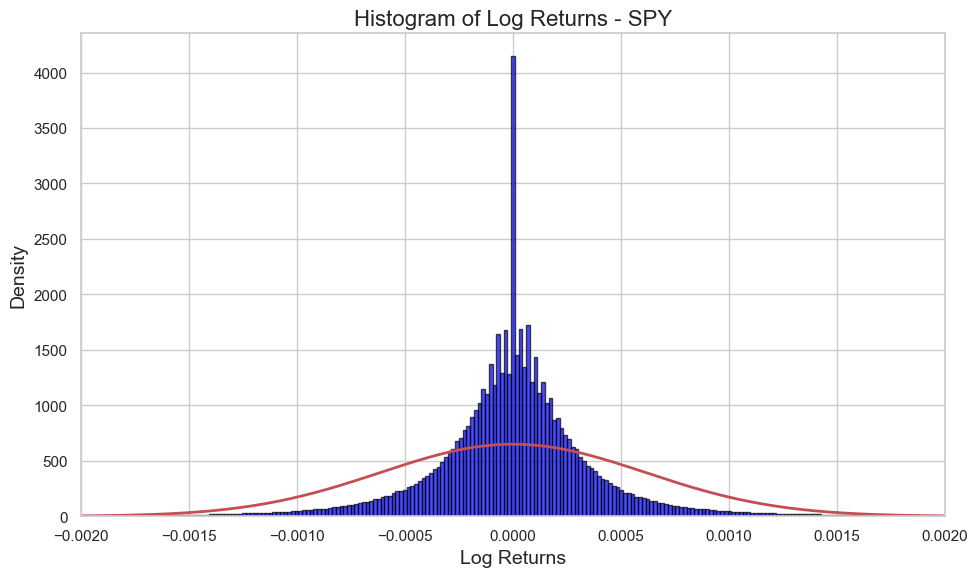

In [40]:
# Histograma de los log-returns
filename = 'SPY_hist_log_ret_2018-2024'
fig, ax = plt.subplots()
log_returns = spy_series_1_filled['log_returns'].dropna()

# Calcular el histograma y obtener los parámetros
count, bins, ignored = ax.hist(log_returns, bins=10000, color='blue', edgecolor='black', alpha=0.7, density=True)

# Ajustar una curva normal a los datos
mu, std = stats.norm.fit(log_returns)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 10000)
p = stats.norm.pdf(x, mu, std)

# Graficar la curva normal ajustada al histograma
ax.plot(x, p, 'r', linewidth=2)

ax.set_title('Histogram of Log Returns - SPY', fontsize=16)
ax.set_xlabel('Log Returns', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([-0.002, 0.002])

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

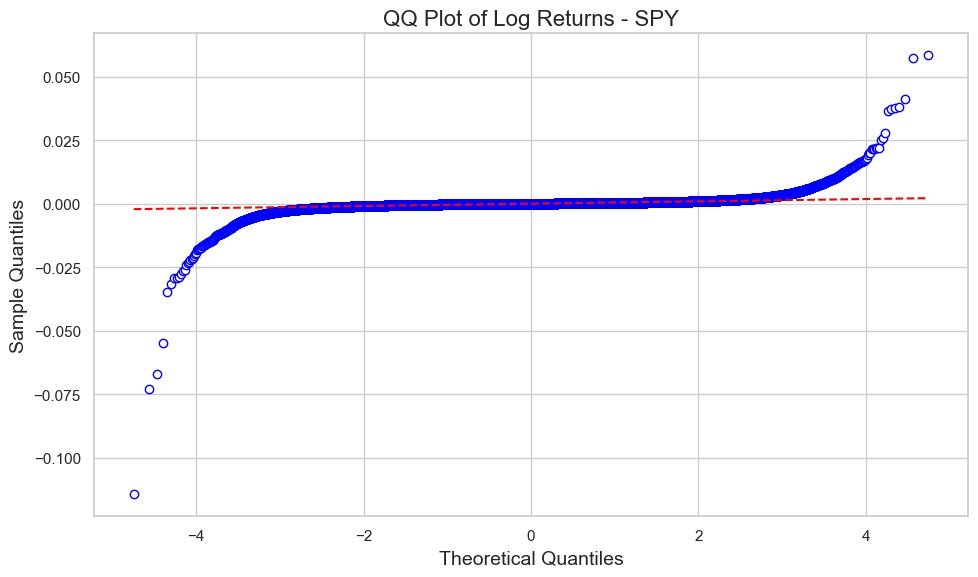

In [41]:
# 3. QQ plot de los log-returns
filename = 'SPY_qq_2018-2024'
fig, ax = plt.subplots()
stats.probplot(spy_series_1_filled['log_returns'].dropna(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('blue')
ax.set_title('QQ Plot of Log Returns - SPY', fontsize=16)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

# Save

Guardado de la serie completa para su uso posterior.

In [42]:
btc_series_1_filled.to_parquet('BTC_all.parquet')
spy_series_1_filled.to_parquet('SPY_all.parquet')